# Road Segmentation with U-Net + DeepLabV3+ Fusion Model

This notebook implements a novel fusion architecture combining U-Net and DeepLabV3+ with EfficientNet-B0 backbone for advanced road image segmentation.

## Dataset Overview:
- **Training Images**: 150 road images
- **Test Images**: 50 road images  
- **Classes**: 19 semantic classes
- **Task**: Road scene understanding and segmentation

## Key Features:
1. **Fusion Architecture** - Novel combination of U-Net skip connections with DeepLabV3+ ASPP module
2. **EfficientNet-B0 Backbone** - Efficient and powerful feature extraction
3. **GFLOP Analysis** - Computational efficiency evaluation
4. **Comprehensive Metrics** - IoU, mIoU, Pixel Accuracy, F1-Score
5. **Advanced Training Techniques** - Mixed precision, gradient clipping
6. **Visualization Tools** - Training progress and prediction analysis
7. **Advanced Data Augmentation** - Comprehensive Albumentations-based augmentation

## Model Architecture:
- **Encoder**: EfficientNet-B0 feature extraction with skip connections
- **Decoder**: Fusion of U-Net upsampling with DeepLabV3+ ASPP features
- **Skip Connections**: Multi-scale feature fusion for fine detail preservation
- **ASPP Module**: Atrous Spatial Pyramid Pooling for multi-scale context

In [1]:
# Essential imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision.models import mobilenet_v2

# Import EfficientNet for new backbone
try:
    from torchvision.models import efficientnet_b0
    print("✅ EfficientNet-B0 available in torchvision")
except ImportError:
    print("⚠️ EfficientNet not available in torchvision, installing efficientnet-pytorch...")
    import os
    os.system("pip install efficientnet-pytorch")
    try:
        from efficientnet_pytorch import EfficientNet
        print("✅ EfficientNet installed successfully")
    except ImportError:
        print("❌ Could not install EfficientNet, will use MobileNetV2 as fallback")
        EfficientNet = None

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
from tqdm import tqdm
import cv2
import json
import time
from collections import defaultdict
import warnings
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Import Albumentations for advanced data augmentation
try:
    import albumentations as A
    print("✅ Albumentations available for advanced augmentation")
except ImportError:
    print("⚠️ Albumentations not available, installing...")
    os.system("pip install albumentations")
    try:
        import albumentations as A
        print("✅ Albumentations installed successfully")
    except ImportError:
        print("❌ Could not install Albumentations, will use basic augmentation")
        A = None

warnings.filterwarnings('ignore')

# For GFLOP calculation
try:
    import torchprofile
    TORCHPROFILE_AVAILABLE = True
    print("✅ torchprofile available for GFLOP calculation")
except ImportError:
    TORCHPROFILE_AVAILABLE = False
    print("⚠️ torchprofile not available, installing...")
    os.system("pip install torchprofile")
    try:
        import torchprofile
        TORCHPROFILE_AVAILABLE = True
        print("✅ torchprofile installed successfully")
    except ImportError:
        TORCHPROFILE_AVAILABLE = False
        print("❌ Could not install torchprofile, GFLOP calculation will be skipped")

# Set device and seeds
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')
if torch.cuda.is_available():
    print(f'GPU: {torch.cuda.get_device_name(0)}')
    print(f'Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB')

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

print("🚀 Setup complete with EfficientNet backbone and advanced augmentation support!")

ModuleNotFoundError: No module named 'torch'

## 1. Dataset Configuration

First, let's configure our road segmentation dataset paths and verify the data structure.

In [2]:
# Dataset configuration for road segmentation
DATA_CONFIG = {
    'data_dir': 'seg_data',
    'train_img_dir': 'seg_data/training/image',
    'train_label_dir': 'seg_data/training/label',
    'test_img_dir': 'seg_data/testing/image', 
    'test_label_dir': 'seg_data/testing/label',
    'num_classes': 19,  # Fixed to match pre-trained model
    'input_size': (512, 512),
    'train_samples': 150,
    'test_samples': 50
}

# Verify dataset structure
def verify_dataset():
    """Verify dataset structure and count samples"""
    print("📁 Dataset Verification:")
    print("-" * 50)
    
    for key, path in DATA_CONFIG.items():
        if 'dir' in key and os.path.exists(path):
            count = len([f for f in os.listdir(path) if f.endswith('.png')])
            print(f"✅ {key}: {count} files")
        elif 'dir' in key:
            print(f"❌ {key}: Directory not found")
    
    print(f"📊 Expected: {DATA_CONFIG['train_samples']} train, {DATA_CONFIG['test_samples']} test images")
    print(f"🎯 Classes: {DATA_CONFIG['num_classes']}")
    print(f"📐 Input size: {DATA_CONFIG['input_size']}")

verify_dataset()

📁 Dataset Verification:
--------------------------------------------------
✅ data_dir: 0 files
✅ train_img_dir: 150 files
✅ train_label_dir: 150 files
✅ test_img_dir: 50 files
✅ test_label_dir: 50 files
📊 Expected: 150 train, 50 test images
🎯 Classes: 19
📐 Input size: (512, 512)


## 2. Advanced Dataset Class

Enhanced dataset class with augmentation support and comprehensive preprocessing.

In [24]:
class RoadSegmentationDataset(Dataset):
    """
    Advanced dataset class for road segmentation with augmentation support
    """
    def __init__(self, image_dir, label_dir, transform=None, target_transform=None, 
                 augment=False, phase='train'):
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.transform = transform
        self.target_transform = target_transform
        self.augment = augment
        self.phase = phase
        
        # Get image files
        self.images = sorted([f for f in os.listdir(image_dir) if f.endswith('.png')])
        print(f"📊 {phase.capitalize()} dataset: {len(self.images)} samples")
        
        # Verify matching labels
        self.verify_data()
    
    def verify_data(self):
        """Verify that all images have corresponding labels"""
        missing_labels = []
        for img_name in self.images:
            label_path = os.path.join(self.label_dir, img_name)
            if not os.path.exists(label_path):
                missing_labels.append(img_name)
        
        if missing_labels:
            print(f"⚠️ Missing labels for: {missing_labels}")
        else:
            print(f"✅ All {len(self.images)} images have corresponding labels")
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        # Load image and label
        img_name = self.images[idx]
        img_path = os.path.join(self.image_dir, img_name)
        label_path = os.path.join(self.label_dir, img_name)
        
        # Load and convert image
        image = Image.open(img_path).convert('RGB')
        label = Image.open(label_path)
        
        # Apply augmentation if enabled
        if self.augment and self.phase == 'train':
            image, label = self.apply_augmentation(image, label)
        
        # Apply transforms
        if self.transform:
            image = self.transform(image)
        
        if self.target_transform:
            label = self.target_transform(label)
        else:
            # Convert to tensor manually
            label = torch.tensor(np.array(label), dtype=torch.long)
        
        return image, label, img_name
    
    def apply_augmentation(self, image, label):
        """Apply comprehensive data augmentation using Albumentations"""
        # Check if Albumentations is available
        if A is None:
            # Fallback to basic augmentation if Albumentations not available
            print("⚠️ Albumentations not available, using basic augmentation")
            if np.random.random() > 0.5:
                image = image.transpose(Image.FLIP_LEFT_RIGHT)
                label = label.transpose(Image.FLIP_LEFT_RIGHT)
            return image, label
        
        # Convert PIL images to numpy arrays for Albumentations
        image_np = np.array(image)
        label_np = np.array(label)
        
        # Define comprehensive augmentation pipeline
        augmentation = A.Compose([
            # === GEOMETRIC AUGMENTATIONS ===
            A.OneOf([
                A.Rotate(limit=15, p=0.7, border_mode=cv2.BORDER_CONSTANT, value=0),
                A.Affine(scale=(0.85, 1.15), translate_percent=(-0.1, 0.1), 
                        rotate=(-10, 10), shear=(-5, 5), p=0.7),
            ], p=0.8),
            
            A.OneOf([
                A.RandomCrop(height=int(512*0.8), width=int(512*0.8), p=0.6),
                A.CenterCrop(height=int(512*0.9), width=int(512*0.9), p=0.4),
            ], p=0.5),
            
            A.HorizontalFlip(p=0.5),
            
            A.OneOf([
                A.ElasticTransform(p=0.3, alpha=50, sigma=5),
                A.GridDistortion(p=0.3, num_steps=5, distort_limit=0.1),
                A.OpticalDistortion(p=0.3, distort_limit=0.1, shift_limit=0.1),
            ], p=0.4),
            
            # === PHOTOMETRIC AUGMENTATIONS ===
            A.OneOf([
                A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1, p=0.8),
                A.HueSaturationValue(hue_shift_limit=15, sat_shift_limit=25, 
                                   val_shift_limit=15, p=0.8),
            ], p=0.7),
            
            A.OneOf([
                A.RandomBrightnessContrast(brightness_limit=0.25, contrast_limit=0.25, p=0.8),
                A.RandomGamma(gamma_limit=(1.0, 1.5), p=0.8),
                A.CLAHE(clip_limit=2.0, tile_grid_size=(8, 8), p=0.6),
            ], p=0.6),
            
            # === WEATHER & LIGHTING EFFECTS ===
            A.OneOf([
        A.RandomRain(slant_lower=-5, slant_upper=5, drop_length=10, 
                   drop_width=1, drop_color=(200, 200, 200), 
                   blur_value=1, brightness_coefficient=0.9, rain_type='default', p=0.3),
                A.RandomFog(fog_coef_lower=0.1, fog_coef_upper=0.3, alpha_coef=0.1, p=0.3),
                A.RandomSunFlare(flare_roi=(0, 0, 1, 0.5), angle_lower=0, angle_upper=1, 
                               num_flare_circles_lower=1, num_flare_circles_upper=3, 
                               src_radius=50, src_color=(255, 255, 255), p=0.2),
            ], p=0.3),
            
            A.OneOf([
                A.RandomShadow(shadow_roi=(0, 0.5, 1, 1), num_shadows_lower=1, 
                             num_shadows_upper=2, shadow_dimension=5, p=0.4),
                A.ToGray(p=0.1),  # Simulate different lighting conditions
            ], p=0.3),
            
            # === NOISE & BLUR AUGMENTATIONS ===
            A.OneOf([
                A.GaussNoise(var_limit=(10.0, 50.0), p=0.6),
                A.ISONoise(color_shift=(0.01, 0.05), intensity=(0.1, 0.5), p=0.6),
                A.MultiplicativeNoise(multiplier=(0.9, 1.1), per_channel=True, p=0.4),
            ], p=0.4),
            
            A.OneOf([
                A.MotionBlur(blur_limit=(3, 7), p=0.5),
                A.GaussianBlur(blur_limit=(1, 3), p=0.5),
                A.Defocus(radius=(1, 3), alias_blur=(0.1, 0.3), p=0.3),
            ], p=0.3),
            
            # === ADVANCED AUGMENTATIONS ===
            A.OneOf([
                A.ChannelShuffle(p=0.3),
                A.ChannelDropout(channel_drop_range=(1, 1), fill_value=127, p=0.2),
                A.CoarseDropout(max_holes=8, max_height=32, max_width=32, 
                              min_holes=1, min_height=8, min_width=8, 
                              fill_value=127, p=0.4),
            ], p=0.3),
            
            A.OneOf([
                A.Sharpen(alpha=(0.1, 0.3), lightness=(0.8, 1.2), p=0.4),
                A.Emboss(alpha=(0.1, 0.3), strength=(0.2, 0.7), p=0.3),
                A.Superpixels(p_replace=(0.05, 0.15), n_segments=(50, 120), p=0.2),
            ], p=0.2),
            
            # Ensure final size is correct
            A.Resize(height=512, width=512, p=1.0),
            
        ], p=1.0)  # Apply augmentation pipeline with 100% probability
        
        # Apply augmentation
        try:
            augmented = augmentation(image=image_np, mask=label_np)
            augmented_image = augmented['image']
            augmented_mask = augmented['mask']
            
            # Convert back to PIL images
            image = Image.fromarray(augmented_image)
            label = Image.fromarray(augmented_mask)
            
        except Exception as e:
            # Fallback to basic augmentation if Albumentations fails
            print(f"⚠️ Augmentation failed, using basic fallback: {e}")
            # Basic horizontal flip fallback
            if np.random.random() > 0.5:
                image = image.transpose(Image.FLIP_LEFT_RIGHT)
                label = label.transpose(Image.FLIP_LEFT_RIGHT)
        
        return image, label
    
    def get_class_distribution(self):
        """Analyze class distribution in the dataset"""
        class_counts = torch.zeros(DATA_CONFIG['num_classes'])
        
        print("🔍 Analyzing class distribution...")
        for idx in tqdm(range(min(len(self), 50))):  # Sample first 50 for speed
            _, label, _ = self[idx]
            unique_classes, counts = torch.unique(label, return_counts=True)
            
            for cls, count in zip(unique_classes, counts):
                if cls < DATA_CONFIG['num_classes']:  # Ignore background/ignore index
                    class_counts[cls] += count
        
        return class_counts

# Create transforms
def get_transforms(phase='train'):
    """Get transforms for different phases"""
    if phase == 'train':
        image_transform = transforms.Compose([
            transforms.Resize(DATA_CONFIG['input_size']),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                               std=[0.229, 0.224, 0.225])
        ])
    else:
        image_transform = transforms.Compose([
            transforms.Resize(DATA_CONFIG['input_size']),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                               std=[0.229, 0.224, 0.225])
        ])
    
    target_transform = transforms.Compose([
        transforms.Resize(DATA_CONFIG['input_size'], interpolation=Image.NEAREST),
        transforms.PILToTensor(),
        transforms.Lambda(lambda x: x.squeeze(0).long())
    ])
    
    return image_transform, target_transform

print("✅ Advanced dataset class with comprehensive Albumentations augmentation defined")

✅ Advanced dataset class with comprehensive Albumentations augmentation defined


## 3. U-Net + DeepLabV3+ Fusion Model Architecture

Implementing a novel fusion architecture that combines the strengths of U-Net and DeepLabV3+ with EfficientNet-B0 backbone for superior road segmentation performance.

### Architecture Overview:
1. **EfficientNet-B0 Encoder**: Efficient feature extraction with multiple skip connections
2. **ASPP Module**: Multi-scale context aggregation from DeepLabV3+
3. **U-Net Decoder**: Progressive upsampling with skip connections for fine detail recovery
4. **Feature Fusion**: Intelligent combination of multi-scale features at each decoder level

In [25]:
class EfficientNetEncoder(nn.Module):
    """EfficientNet-B0 encoder with skip connections for U-Net style architecture"""
    def __init__(self, pretrained=True):
        super(EfficientNetEncoder, self).__init__()
        
        # Load EfficientNet-B0
        try:
            self.backbone = efficientnet_b0(pretrained=pretrained)
            self.backbone_type = "torchvision"
        except:
            # Fallback to efficientnet-pytorch
            try:
                self.backbone = EfficientNet.from_pretrained('efficientnet-b0') if pretrained else EfficientNet.from_name('efficientnet-b0')
                self.backbone_type = "efficientnet_pytorch"
            except:
                raise ImportError("Could not load EfficientNet. Please install either torchvision>=0.13 or efficientnet-pytorch")
        
        # Extract feature layers for skip connections
        if self.backbone_type == "torchvision":
            self.features = self.backbone.features
            # EfficientNet-B0 feature channels: [16, 24, 40, 80, 112, 192, 320, 1280]
            self.skip_channels = [16, 24, 40, 80, 112, 192, 320]
            self.final_channels = 1280
        else:
            # efficientnet-pytorch version
            self.features = self.backbone
            self.skip_channels = [16, 24, 40, 80, 112, 192, 320]
            self.final_channels = 1280
    
    def forward(self, x):
        skip_features = []
        
        if self.backbone_type == "torchvision":
            # Extract features at different scales
            for i, layer in enumerate(self.features):
                x = layer(x)
                # Collect skip connection features at specific indices
                if i in [1, 2, 3, 4, 5, 6, 7]:  # Adjust indices based on EfficientNet-B0 structure
                    skip_features.append(x)
        else:
            # For efficientnet-pytorch version
            x = self.features.extract_features(x)
            # This version requires manual feature extraction - implement based on specific needs
            
        return x, skip_features


class ASPP(nn.Module):
    """Enhanced Atrous Spatial Pyramid Pooling module"""
    def __init__(self, in_channels, out_channels=256, rates=[6, 12, 18, 24]):
        super(ASPP, self).__init__()

        # 1x1 convolution
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

        # Atrous convolutions with different dilation rates
        self.atrous_convs = nn.ModuleList()
        for rate in rates:
            self.atrous_convs.append(nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 3, padding=rate, 
                         dilation=rate, bias=False),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True)
            ))

        # Global average pooling branch
        self.global_avg_pool = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(in_channels, out_channels, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

        # Final projection layer
        total_channels = out_channels * (len(rates) + 2)  # +2 for 1x1 conv and global pooling
        self.project = nn.Sequential(
            nn.Conv2d(total_channels, out_channels, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5)
        )

    def forward(self, x):
        size = x.shape[-2:]
        
        # Apply different ASPP branches
        features = [self.conv1(x)]
        
        # Add atrous convolutions
        for atrous_conv in self.atrous_convs:
            features.append(atrous_conv(x))
        
        # Add global average pooling
        global_feat = F.interpolate(self.global_avg_pool(x), size=size, 
                                  mode='bilinear', align_corners=False)
        features.append(global_feat)

        # Concatenate all branches
        x = torch.cat(features, dim=1)
        x = self.project(x)

        return x


class FusionBlock(nn.Module):
    """Feature fusion block for combining skip connections with upsampled features"""
    def __init__(self, high_channels, skip_channels, out_channels):
        super(FusionBlock, self).__init__()
        
        # Process skip connection features
        self.skip_conv = nn.Sequential(
            nn.Conv2d(skip_channels, out_channels//2, 1, bias=False),
            nn.BatchNorm2d(out_channels//2),
            nn.ReLU(inplace=True)
        )
        
        # Process high-level features
        self.high_conv = nn.Sequential(
            nn.Conv2d(high_channels, out_channels//2, 1, bias=False),
            nn.BatchNorm2d(out_channels//2),
            nn.ReLU(inplace=True)
        )
        
        # Fusion convolution
        self.fusion = nn.Sequential(
            nn.Conv2d(out_channels, out_channels, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
        
    def forward(self, high_feat, skip_feat):
        # Upsample high-level features to match skip features
        high_feat = F.interpolate(high_feat, size=skip_feat.shape[-2:], 
                                mode='bilinear', align_corners=False)
        
        # Process features
        skip_processed = self.skip_conv(skip_feat)
        high_processed = self.high_conv(high_feat)
        
        # Concatenate and fuse
        fused = torch.cat([skip_processed, high_processed], dim=1)
        return self.fusion(fused)


class UNetDeepLabFusion(nn.Module):
    """Fusion model combining U-Net decoder with DeepLabV3+ ASPP and EfficientNet-B0 encoder"""
    def __init__(self, num_classes=19, pretrained=True):
        super(UNetDeepLabFusion, self).__init__()
        
        self.num_classes = num_classes
        
        # EfficientNet-B0 encoder
        self.encoder = EfficientNetEncoder(pretrained=pretrained)
        
        # ASPP module for high-level feature processing
        self.aspp = ASPP(self.encoder.final_channels, 256)
        
        # Decoder fusion blocks - progressive upsampling with skip connections
        # EfficientNet-B0 skip channels: [16, 24, 40, 80, 112, 192, 320]
        self.decoder_channels = [256, 192, 128, 96, 64, 48, 32]
        
        self.fusion_blocks = nn.ModuleList([
            FusionBlock(256, 320, self.decoder_channels[0]),  # Highest skip connection
            FusionBlock(self.decoder_channels[0], 192, self.decoder_channels[1]),
            FusionBlock(self.decoder_channels[1], 112, self.decoder_channels[2]),
            FusionBlock(self.decoder_channels[2], 80, self.decoder_channels[3]),
            FusionBlock(self.decoder_channels[3], 40, self.decoder_channels[4]),
            FusionBlock(self.decoder_channels[4], 24, self.decoder_channels[5]),
            FusionBlock(self.decoder_channels[5], 16, self.decoder_channels[6])
        ])
        
        # Final upsampling and classification
        self.final_upsample = nn.Sequential(
            nn.ConvTranspose2d(self.decoder_channels[6], 32, 4, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(32, 16, 4, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True)
        )
        
        # Final classifier
        self.classifier = nn.Conv2d(16, num_classes, 1)
        
        # Initialize weights
        self._init_weights()
    
    def _init_weights(self):
        """Initialize model weights"""
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        input_size = x.shape[-2:]
        
        # Extract features from encoder
        features, skip_features = self.encoder(x)
        
        # Process through ASPP
        x = self.aspp(features)
        
        # Progressive decoding with skip connections
        # Reverse skip features to match decoder order (highest resolution first)
        skip_features = skip_features[::-1]
        
        for i, fusion_block in enumerate(self.fusion_blocks):
            if i < len(skip_features):
                x = fusion_block(x, skip_features[i])
            else:
                # If we run out of skip features, just upsample
                x = F.interpolate(x, scale_factor=2, mode='bilinear', align_corners=False)
        
        # Final upsampling and classification
        x = self.final_upsample(x)
        x = self.classifier(x)
        
        # Ensure output matches input size
        if x.shape[-2:] != input_size:
            x = F.interpolate(x, size=input_size, mode='bilinear', align_corners=False)
        
        return x
    
    def freeze_encoder(self):
        """Freeze encoder parameters"""
        for param in self.encoder.parameters():
            param.requires_grad = False
            
    def unfreeze_encoder(self):
        """Unfreeze encoder parameters"""
        for param in self.encoder.parameters():
            param.requires_grad = True
    
    def get_parameter_groups(self, lr_encoder=1e-4, lr_decoder=1e-3):
        """Get parameter groups with different learning rates"""
        encoder_params = list(self.encoder.parameters())
        decoder_params = list(self.aspp.parameters()) + \
                        list(self.fusion_blocks.parameters()) + \
                        list(self.final_upsample.parameters()) + \
                        list(self.classifier.parameters())
        
        return [
            {'params': encoder_params, 'lr': lr_encoder},
            {'params': decoder_params, 'lr': lr_decoder}
        ]

print("✅ U-Net + DeepLabV3+ Fusion model with EfficientNet-B0 backbone defined")

✅ U-Net + DeepLabV3+ Fusion model with EfficientNet-B0 backbone defined


## 3.1 Model Architecture Details

Our fusion model combines the best aspects of both U-Net and DeepLabV3+ architectures:

### Key Components:

1. **EfficientNet-B0 Encoder**: 
   - Efficient feature extraction with compound scaling
   - Multiple skip connections at different scales
   - Pre-trained on ImageNet for transfer learning
   - Feature channels: [16, 24, 40, 80, 112, 192, 320, 1280]

2. **ASPP (Atrous Spatial Pyramid Pooling)**:
   - Multi-scale context aggregation
   - Dilated convolutions with rates [6, 12, 18, 24]
   - Global average pooling for global context
   - Enhanced from DeepLabV3+ design

3. **Fusion Decoder**:
   - Progressive upsampling with skip connections (U-Net style)
   - Feature fusion blocks at each decoder level
   - Intelligent combination of high-level and low-level features
   - Preserves fine details while maintaining semantic understanding

4. **Multi-Scale Feature Integration**:
   - Skip connections from multiple encoder levels
   - Feature alignment and fusion at each decoder stage
   - Adaptive feature processing for optimal information flow

### Advantages of this Approach:
- **Better Feature Utilization**: Combines multi-scale features effectively
- **Improved Detail Preservation**: U-Net skip connections preserve fine structures
- **Enhanced Context Understanding**: ASPP module captures multi-scale context
- **Efficient Backbone**: EfficientNet-B0 provides excellent accuracy/efficiency trade-off
- **Gradient Flow**: Better gradient propagation through multiple pathways

In [15]:
# U-Net Implementation

class ConvBlock(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""
    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class Down(nn.Module):
    """Downscaling with maxpool then double conv"""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            ConvBlock(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)

class Up(nn.Module):
    """Upscaling then double conv"""
    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = ConvBlock(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = ConvBlock(in_channels, out_channels) # Corrected: in_channels should be sum of skip and upsampled

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        
        # Concatenate along the channel dimension
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True, base_c=64):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = ConvBlock(n_channels, base_c)
        self.down1 = Down(base_c, base_c*2)
        self.down2 = Down(base_c*2, base_c*4)
        self.down3 = Down(base_c*4, base_c*8)
        factor = 2 if bilinear else 1
        self.down4 = Down(base_c*8, base_c*16 // factor)
        
        self.up1 = Up(base_c*16, base_c*8 // factor, bilinear) # up(1024, 512) with base_c=64
        self.up2 = Up(base_c*8, base_c*4 // factor, bilinear)  # up(512, 256)
        self.up3 = Up(base_c*4, base_c*2 // factor, bilinear)  # up(256, 128)
        self.up4 = Up(base_c*2, base_c, bilinear)             # up(128, 64)
        self.outc = OutConv(base_c, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

print("✅ U-Net model architecture defined")

# Model Instantiation and Configuration

def create_model(model_type='fusion', num_classes=19, pretrained=True):
    """Create and configure the segmentation model"""
    
    if model_type == 'fusion':
        model = UNetDeepLabFusion(num_classes=num_classes, pretrained=pretrained)
        print(f"\u2705 Created U-Net + DeepLabV3+ Fusion model with EfficientNet-B0 backbone")
    else:
        raise ValueError(f"Unsupported model type: {model_type}")
    
    return model

# Create the fusion model
model = create_model('fusion', num_classes=DATA_CONFIG['num_classes'], pretrained=True)
model = model.to(device)

print(f"\n\ud83d\udcca Model Summary:")
print(f"Model type: U-Net + DeepLabV3+ Fusion")
print(f"Backbone: EfficientNet-B0")
print(f"Classes: {DATA_CONFIG['num_classes']}")
print(f"Device: {device}")

# Model configuration for different training phases
class TrainingConfig:
    """Training configuration for different phases"""
    def __init__(self):
        # Phase 1: Encoder frozen, decoder training
        self.phase1 = {
            'epochs': 15,
            'lr_encoder': 0.0,
            'lr_decoder': 1e-3,
            'freeze_encoder': True,
            'description': 'Decoder training with frozen encoder'
        }
        
        # Phase 2: Full model training with different learning rates
        self.phase2 = {
            'epochs': 20,
            'lr_encoder': 5e-5,
            'lr_decoder': 5e-4,
            'freeze_encoder': False,
            'description': 'Full model training with differential learning rates'
        }
        
        # Phase 3: Fine-tuning with low learning rate
        self.phase3 = {
            'epochs': 10,
            'lr_encoder': 1e-5,
            'lr_decoder': 1e-4,
            'freeze_encoder': False,
            'description': 'Fine-tuning with low learning rates'
        }

training_config = TrainingConfig()
print(f"\n\ud83d\udee0\ufe0f Training phases configured:")
print(f"Phase 1: {training_config.phase1['description']} ({training_config.phase1['epochs']} epochs)")
print(f"Phase 2: {training_config.phase2['description']} ({training_config.phase2['epochs']} epochs)")
print(f"Phase 3: {training_config.phase3['description']} ({training_config.phase3['epochs']} epochs)")

print("\u2705 Model instantiation and configuration complete")

# Model Testing and Validation Setup

def test_model_forward_pass():
    """Test the fusion model with a dummy input to ensure it works correctly"""
    print("\ud83e\uddea Testing Fusion Model Forward Pass...")
    
    # Create a dummy input
    dummy_input = torch.randn(1, 3, 512, 512).to(device)
    
    model.eval()
    with torch.no_grad():
        try:
            output = model(dummy_input)
            print(f"\u2705 Forward pass successful!")
            print(f"   Input shape: {dummy_input.shape}")
            print(f"   Output shape: {output.shape}")
            print(f"   Expected shape: (1, {DATA_CONFIG['num_classes']}, 512, 512)")
            
            # Check if output shape is correct
            expected_shape = (1, DATA_CONFIG['num_classes'], 512, 512)
            if output.shape == expected_shape:
                print(f"\u2705 Output shape is correct")
            else:
                print(f"\u26a0\ufe0f Output shape mismatch: got {output.shape}, expected {expected_shape}")
                
            return True
        except Exception as e:
            print(f"\u274c Forward pass failed: {e}")
            return False

def validate_model_components():
    """Validate that all model components are working correctly"""
    print("\n\ud83d\udd0d Validating Model Components...")
    
    # Check encoder
    try:
        dummy_input = torch.randn(1, 3, 512, 512).to(device)
        features, skip_features = model.encoder(dummy_input)
        print(f"\u2705 Encoder working - Features: {features.shape}, Skip connections: {len(skip_features)}")
    except Exception as e:
        print(f"\u274c Encoder error: {e}")
        return False
    
    # Check ASPP
    try:
        aspp_output = model.aspp(features)
        print(f"\u2705 ASPP working - Output: {aspp_output.shape}")
    except Exception as e:
        print(f"\u274c ASPP error: {e}")
        return False
    
    print(f"\u2705 All model components validated successfully")
    return True

# Test the fusion model
if test_model_forward_pass() and validate_model_components():
    print(f"\n\ud83c\udf89 U-Net + DeepLabV3+ Fusion Model is ready for training!")
else:
    print(f"\n\u274c Model validation failed - please check the implementation")

print("\u2705 Model testing and validation complete")

✅ U-Net model architecture defined


Exception in callback BaseAsyncIOLoop._handle_events(1272, 1)
handle: <Handle BaseAsyncIOLoop._handle_events(1272, 1)>
Traceback (most recent call last):
  File "c:\Users\admin\anaconda3\envs\ai+cv\lib\site-packages\jupyter_client\session.py", line 99, in json_packer
    return json.dumps(
UnicodeEncodeError: 'utf-8' codec can't encode characters in position 217-218: surrogates not allowed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "c:\Users\admin\anaconda3\envs\ai+cv\lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "c:\Users\admin\anaconda3\envs\ai+cv\lib\site-packages\tornado\platform\asyncio.py", line 202, in _handle_events
    handler_func(fileobj, events)
  File "c:\Users\admin\anaconda3\envs\ai+cv\lib\site-packages\zmq\eventloop\zmqstream.py", line 578, in _handle_events
    self._handle_recv()
  File "c:\Users\admin\anaconda3\envs\ai+cv\lib\site-packages\zmq\eve

## 4. GFLOP Analysis Functions

Functions to calculate and analyze computational complexity (GFLOP - Giga Floating Point Operations).

In [16]:
def calculate_gflops(model, input_size=(1, 3, 512, 512)):
    """
    Calculate GFLOP (Giga Floating Point Operations) for the model
    """
    if not TORCHPROFILE_AVAILABLE:
        print("⚠️ torchprofile not available, cannot calculate GFLOPs")
        return None
    
    model.eval()
    dummy_input = torch.randn(input_size).to(next(model.parameters()).device)
    
    try:
        with torch.no_grad():
            flops = torchprofile.profile_macs(model, dummy_input) / 1e9  # Convert to GFLOP
        return flops
    except Exception as e:
        print(f"❌ Error calculating GFLOPs: {e}")
        return None

def analyze_model_complexity(model, input_size=(1, 3, 512, 512)):
    """
    Comprehensive model complexity analysis
    """
    print("🔍 Model Complexity Analysis")
    print("=" * 60)
    
    # Parameter count
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    
    print(f"📊 Parameters:")
    print(f"   Total parameters: {total_params:,}")
    print(f"   Trainable parameters: {trainable_params:,}")
    print(f"   Frozen parameters: {total_params - trainable_params:,}")
    print(f"   Trainable ratio: {trainable_params/total_params:.1%}")
    
    # Model size estimation
    param_size = total_params * 4 / (1024 ** 2)  # Assume float32, convert to MB
    print(f"   Estimated model size: {param_size:.1f} MB")
    
    # GFLOP calculation
    gflops = calculate_gflops(model, input_size)
    if gflops is not None:
        print(f"\n⚡ Computational Complexity:")
        print(f"   GFLOPs: {gflops:.2f}")
        print(f"   Memory per forward pass: ~{gflops * 4:.1f} MB (estimated)")
    
    # Inference speed test
    print(f"\n⏱️ Inference Speed Test:")
    model.eval()
    device = next(model.parameters()).device
    dummy_input = torch.randn(input_size).to(device)
    
    # Warmup
    with torch.no_grad():
        for _ in range(10):
            _ = model(dummy_input)
    
    # Timing
    torch.cuda.synchronize() if device.type == 'cuda' else None
    start_time = time.time()
    
    with torch.no_grad():
        for _ in range(100):
            _ = model(dummy_input)
    
    torch.cuda.synchronize() if device.type == 'cuda' else None
    end_time = time.time()
    
    avg_time = (end_time - start_time) / 100
    fps = 1 / avg_time
    
    print(f"   Average inference time: {avg_time*1000:.1f} ms")
    print(f"   Estimated FPS: {fps:.1f}")
    
    return {
        'total_params': total_params,
        'trainable_params': trainable_params,
        'model_size_mb': param_size,
        'gflops': gflops,
        'inference_time_ms': avg_time * 1000,
        'fps': fps
    }

def compare_model_efficiency(model_before, model_after):
    """Compare efficiency metrics before and after fine-tuning"""
    print("📈 Model Efficiency Comparison")
    print("=" * 60)
    
    metrics_before = analyze_model_complexity(model_before)
    print("\n" + "-" * 60)
    metrics_after = analyze_model_complexity(model_after)
    
    # Print comparison
    print(f"\n📊 Comparison Summary:")
    if metrics_before['gflops'] and metrics_after['gflops']:
        gflop_change = metrics_after['gflops'] - metrics_before['gflops']
        print(f"   GFLOP change: {gflop_change:+.2f} ({gflop_change/metrics_before['gflops']*100:+.1f}%)")
    
    speed_change = metrics_after['inference_time_ms'] - metrics_before['inference_time_ms']
    print(f"   Speed change: {speed_change:+.1f} ms ({speed_change/metrics_before['inference_time_ms']*100:+.1f}%)")

print("✅ GFLOP analysis functions defined")

✅ GFLOP analysis functions defined


## 5. Advanced Training Utilities

Comprehensive training utilities including metrics, visualization, and monitoring tools.

In [17]:
class SegmentationMetrics:
    """Optimized metrics for segmentation evaluation"""
    
    def __init__(self, num_classes, ignore_index=255):
        self.num_classes = num_classes
        self.ignore_index = ignore_index
        self.reset()
    
    def reset(self):
        self.confusion_matrix = torch.zeros((self.num_classes, self.num_classes))
        self.total_samples = 0
    
    def update(self, predictions, targets):
        """Update metrics with batch predictions and targets - OPTIMIZED"""
        # Move to CPU for faster computation
        if predictions.is_cuda:
            predictions = predictions.cpu()
        if targets.is_cuda:
            targets = targets.cpu()
            
        # Flatten tensors
        predictions = predictions.view(-1)
        targets = targets.view(-1)
        
        # Remove ignore index
        valid_mask = targets != self.ignore_index
        predictions = predictions[valid_mask]
        targets = targets[valid_mask]
        
        if len(predictions) == 0:
            return
        
        # Clip predictions and targets to valid range
        predictions = torch.clamp(predictions, 0, self.num_classes - 1)
        targets = torch.clamp(targets, 0, self.num_classes - 1)
        
        # Vectorized confusion matrix update
        indices = targets * self.num_classes + predictions
        cm_update = torch.bincount(indices, minlength=self.num_classes**2)
        cm_update = cm_update.view(self.num_classes, self.num_classes)
        
        self.confusion_matrix += cm_update.float()
        self.total_samples += len(predictions)
    
    def compute_metrics(self):
        """Compute all segmentation metrics"""
        cm = self.confusion_matrix
        
        # Per-class IoU
        intersection = torch.diag(cm)
        union = cm.sum(dim=1) + cm.sum(dim=0) - intersection
        iou_per_class = intersection / (union + 1e-8)
        
        # Mean IoU
        valid_classes = union > 0
        miou = iou_per_class[valid_classes].mean()
        
        # Pixel accuracy
        pixel_acc = intersection.sum() / cm.sum()
        
        # Per-class accuracy
        acc_per_class = intersection / (cm.sum(dim=1) + 1e-8)
        
        # Mean accuracy
        mean_acc = acc_per_class[valid_classes].mean()
        
        # Frequency weighted IoU
        freq = cm.sum(dim=1) / cm.sum()
        freq_weighted_iou = (freq[valid_classes] * iou_per_class[valid_classes]).sum()
        
        return {
            'pixel_accuracy': pixel_acc.item(),
            'mean_accuracy': mean_acc.item(),
            'mean_iou': miou.item(),
            'frequency_weighted_iou': freq_weighted_iou.item(),
            'iou_per_class': iou_per_class.tolist(),
            'accuracy_per_class': acc_per_class.tolist(),
            'confusion_matrix': cm.numpy()
        }

class TrainingMonitor:
    """Monitor and log training progress"""
    
    def __init__(self):
        self.history = {
            'train_loss': [],
            'val_loss': [],
            'train_miou': [],
            'val_miou': [],
            'train_pixel_acc': [],
            'val_pixel_acc': [],
            'learning_rates': [],
            'epoch_times': []
        }
        self.best_val_miou = 0.0
        self.best_epoch = 0
    
    def update(self, epoch, train_metrics, val_metrics, lr, epoch_time):
        """Update training history"""
        self.history['train_loss'].append(train_metrics['loss'])
        self.history['val_loss'].append(val_metrics['loss'])
        self.history['train_miou'].append(train_metrics['mean_iou'])
        self.history['val_miou'].append(val_metrics['mean_iou'])
        self.history['train_pixel_acc'].append(train_metrics['pixel_accuracy'])
        self.history['val_pixel_acc'].append(val_metrics['pixel_accuracy'])
        self.history['learning_rates'].append(lr)
        self.history['epoch_times'].append(epoch_time)
        
        # Track best model
        if val_metrics['mean_iou'] > self.best_val_miou:
            self.best_val_miou = val_metrics['mean_iou']
            self.best_epoch = epoch
    
    def plot_training_curves(self):
        """Plot comprehensive training curves"""
        fig, axes = plt.subplots(2, 3, figsize=(18, 10))
        
        epochs = range(1, len(self.history['train_loss']) + 1)
        
        # Loss curves
        axes[0, 0].plot(epochs, self.history['train_loss'], 'b-', label='Train Loss')
        axes[0, 0].plot(epochs, self.history['val_loss'], 'r-', label='Val Loss')
        axes[0, 0].set_title('Loss Curves')
        axes[0, 0].set_xlabel('Epoch')
        axes[0, 0].set_ylabel('Loss')
        axes[0, 0].legend()
        axes[0, 0].grid(True)
        
        # mIoU curves
        axes[0, 1].plot(epochs, self.history['train_miou'], 'b-', label='Train mIoU')
        axes[0, 1].plot(epochs, self.history['val_miou'], 'r-', label='Val mIoU')
        axes[0, 1].axhline(y=self.best_val_miou, color='g', linestyle='--', 
                          label=f'Best: {self.best_val_miou:.3f}')
        axes[0, 1].set_title('Mean IoU Curves')
        axes[0, 1].set_xlabel('Epoch')
        axes[0, 1].set_ylabel('mIoU')
        axes[0, 1].legend()
        axes[0, 1].grid(True)
        
        # Pixel accuracy curves
        axes[0, 2].plot(epochs, self.history['train_pixel_acc'], 'b-', label='Train Pixel Acc')
        axes[0, 2].plot(epochs, self.history['val_pixel_acc'], 'r-', label='Val Pixel Acc')
        axes[0, 2].set_title('Pixel Accuracy Curves')
        axes[0, 2].set_xlabel('Epoch')
        axes[0, 2].set_ylabel('Accuracy')
        axes[0, 2].legend()
        axes[0, 2].grid(True)
        
        # Learning rate schedule
        axes[1, 0].plot(epochs, self.history['learning_rates'], 'g-')
        axes[1, 0].set_title('Learning Rate Schedule')
        axes[1, 0].set_xlabel('Epoch')
        axes[1, 0].set_ylabel('Learning Rate')
        axes[1, 0].set_yscale('log')
        axes[1, 0].grid(True)
        
        # Training time per epoch
        axes[1, 1].plot(epochs, self.history['epoch_times'], 'orange')
        axes[1, 1].set_title('Training Time per Epoch')
        axes[1, 1].set_xlabel('Epoch')
        axes[1, 1].set_ylabel('Time (seconds)')
        axes[1, 1].grid(True)
        
        # Validation improvement
        val_improvements = []
        best_so_far = 0
        for val_miou in self.history['val_miou']:
            if val_miou > best_so_far:
                val_improvements.append(val_miou)
                best_so_far = val_miou
            else:
                val_improvements.append(best_so_far)
        
        axes[1, 2].plot(epochs, val_improvements, 'purple')
        axes[1, 2].set_title('Best Validation mIoU Progress')
        axes[1, 2].set_xlabel('Epoch')
        axes[1, 2].set_ylabel('Best mIoU')
        axes[1, 2].grid(True)
        
        plt.tight_layout()
        plt.show()
    
    def print_summary(self):
        """Print training summary"""
        print(f"\n📈 Training Summary:")
        print(f"   Best validation mIoU: {self.best_val_miou:.4f} (epoch {self.best_epoch})")
        print(f"   Final train loss: {self.history['train_loss'][-1]:.4f}")
        print(f"   Final val loss: {self.history['val_loss'][-1]:.4f}")
        print(f"   Average epoch time: {np.mean(self.history['epoch_times']):.1f}s")
        print(f"   Total training time: {sum(self.history['epoch_times'])/3600:.2f}h")

print("✅ Optimized training utilities defined")

✅ Optimized training utilities defined


## 5.5. Enhanced Loss Functions

Implementation of advanced loss functions for better road segmentation performance:
- **FocalLoss**: Addresses class imbalance by focusing on hard examples
- **DiceLoss**: Better for segmentation tasks, handles class imbalance naturally
- **CombinedLoss**: Weighted combination of CrossEntropy + Dice + Focal losses

In [18]:
import torch.nn.functional as F

class FocalLoss(nn.Module):
    """Focal Loss for addressing class imbalance in segmentation.
    
    Args:
        alpha: Weighting factor for rare class (default: 1.0)
        gamma: Focusing parameter (default: 2.0)
        ignore_index: Index to ignore in loss computation
        reduction: Loss reduction method
    """
    
    def __init__(self, alpha=1.0, gamma=2.0, ignore_index=255, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.ignore_index = ignore_index
        self.reduction = reduction
        
    def forward(self, inputs, targets):
        # Get valid mask (ignore pixels with ignore_index)
        valid_mask = (targets != self.ignore_index)
        
        if not valid_mask.any():
            return torch.tensor(0.0, device=inputs.device, requires_grad=True)
        
        # Apply softmax to get probabilities
        ce_loss = F.cross_entropy(inputs, targets, ignore_index=self.ignore_index, reduction='none')
        pt = torch.exp(-ce_loss)
        
        # Apply focal loss formula: -alpha * (1-pt)^gamma * log(pt)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * ce_loss
        
        # Only consider valid pixels
        focal_loss = focal_loss[valid_mask]
        
        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss


class DiceLoss(nn.Module):
    """Dice Loss for segmentation tasks.
    
    Args:
        smooth: Smoothing factor to avoid division by zero
        ignore_index: Index to ignore in loss computation
    """
    
    def __init__(self, smooth=1.0, ignore_index=255):
        super(DiceLoss, self).__init__()
        self.smooth = smooth
        self.ignore_index = ignore_index
        
    def forward(self, inputs, targets):
        # Get valid mask
        valid_mask = (targets != self.ignore_index)
        
        if not valid_mask.any():
            return torch.tensor(0.0, device=inputs.device, requires_grad=True)
        
        # Apply softmax to get probabilities
        probs = F.softmax(inputs, dim=1)
        num_classes = inputs.size(1)
        
        # Convert targets to one-hot encoding
        targets_one_hot = F.one_hot(targets, num_classes=num_classes).permute(0, 3, 1, 2).float()
        
        # Apply valid mask to both predictions and targets
        valid_mask_expanded = valid_mask.unsqueeze(1).expand_as(probs)
        probs = probs * valid_mask_expanded
        targets_one_hot = targets_one_hot * valid_mask_expanded
        
        # Calculate Dice coefficient for each class
        intersection = (probs * targets_one_hot).sum(dim=(2, 3))
        union = probs.sum(dim=(2, 3)) + targets_one_hot.sum(dim=(2, 3))
        
        dice_coeff = (2.0 * intersection + self.smooth) / (union + self.smooth)
        
        # Calculate dice loss (1 - dice_coefficient)
        dice_loss = 1.0 - dice_coeff
        
        # Average across classes and batch
        return dice_loss.mean()


class CombinedLoss(nn.Module):
    """Combined loss function using CrossEntropy + Dice + Focal losses.
    
    Args:
        ce_weight: Weight for CrossEntropy loss
        dice_weight: Weight for Dice loss  
        focal_weight: Weight for Focal loss
        focal_alpha: Alpha parameter for Focal loss
        focal_gamma: Gamma parameter for Focal loss
        ignore_index: Index to ignore in loss computation
        label_smoothing: Label smoothing for CrossEntropy
    """
    
    def __init__(self, 
                 ce_weight=1.0, 
                 dice_weight=1.0, 
                 focal_weight=1.0,
                 focal_alpha=1.0,
                 focal_gamma=2.0,
                 ignore_index=255,
                 label_smoothing=0.1):
        super(CombinedLoss, self).__init__()
        
        self.ce_weight = ce_weight
        self.dice_weight = dice_weight
        self.focal_weight = focal_weight
        
        # Initialize individual loss functions
        self.ce_loss = nn.CrossEntropyLoss(ignore_index=ignore_index, 
                                         label_smoothing=label_smoothing)
        self.dice_loss = DiceLoss(ignore_index=ignore_index)
        self.focal_loss = FocalLoss(alpha=focal_alpha, 
                                  gamma=focal_gamma, 
                                  ignore_index=ignore_index)
        
    def forward(self, inputs, targets):
        # Calculate individual losses
        ce_loss_val = self.ce_loss(inputs, targets)
        dice_loss_val = self.dice_loss(inputs, targets) 
        focal_loss_val = self.focal_loss(inputs, targets)
        
        # Combine losses with weights
        total_loss = (
            self.ce_weight * ce_loss_val +
            self.dice_weight * dice_loss_val +
            self.focal_weight * focal_loss_val
        )
        
        return total_loss, {
            'ce_loss': ce_loss_val.item(),
            'dice_loss': dice_loss_val.item(),
            'focal_loss': focal_loss_val.item(),
            'total_loss': total_loss.item()
        }


def get_loss_function(loss_type='combined', **kwargs):
    """Factory function to get different loss functions.
    
    Args:
        loss_type: Type of loss ('ce', 'focal', 'dice', 'combined')
        **kwargs: Additional parameters for loss functions
        
    Returns:
        Loss function instance
    """
    if loss_type == 'ce':
        return nn.CrossEntropyLoss(ignore_index=kwargs.get('ignore_index', 255),
                                 label_smoothing=kwargs.get('label_smoothing', 0.1))
    elif loss_type == 'focal':
        return FocalLoss(alpha=kwargs.get('focal_alpha', 1.0),
                        gamma=kwargs.get('focal_gamma', 2.0),
                        ignore_index=kwargs.get('ignore_index', 255))
    elif loss_type == 'dice':
        return DiceLoss(ignore_index=kwargs.get('ignore_index', 255))
    elif loss_type == 'combined':
        return CombinedLoss(
            ce_weight=kwargs.get('ce_weight', 1.0),
            dice_weight=kwargs.get('dice_weight', 1.0),
            focal_weight=kwargs.get('focal_weight', 1.0),
            focal_alpha=kwargs.get('focal_alpha', 1.0),
            focal_gamma=kwargs.get('focal_gamma', 2.0),
            ignore_index=kwargs.get('ignore_index', 255),
            label_smoothing=kwargs.get('label_smoothing', 0.1)
        )
    else:
        raise ValueError(f"Unknown loss type: {loss_type}")

print("✅ Enhanced loss functions implemented")
print("   📌 FocalLoss: Addresses class imbalance, focuses on hard examples")
print("   📌 DiceLoss: Better for segmentation, handles class imbalance")
print("   📌 CombinedLoss: Weighted combination of CE + Dice + Focal")
print("   📌 Factory function available for easy loss selection")

✅ Enhanced loss functions implemented
   📌 FocalLoss: Addresses class imbalance, focuses on hard examples
   📌 DiceLoss: Better for segmentation, handles class imbalance
   📌 CombinedLoss: Weighted combination of CE + Dice + Focal
   📌 Factory function available for easy loss selection


## 6. Simple Training Implementation

Implementation of straightforward training approach for the EfficientNet + fusion model without progressive fine-tuning.

### Training Strategy:
- **Direct Training**: Train the complete EfficientNet-B0 + U-Net + DeepLabV3+ fusion model from the start
- **Differential Learning Rates**: Lower learning rate for pre-trained encoder, higher for fusion decoder
- **Combined Loss Function**: Weighted combination of CrossEntropy + Dice + Focal losses
- **CosineAnnealingLR Scheduler**: Smooth learning rate decay for stable convergence
- **Automatic Model Saving**: Save best model based on validation mIoU

### Key Features:
- ✅ **Simplified Approach**: No complex progressive training phases
- ✅ **Efficient Training**: Direct optimization of the fusion architecture
- ✅ **Robust Loss Function**: Combined loss handles class imbalance and segmentation quality
- ✅ **Smart Learning Rates**: Differential rates for encoder vs decoder components
- ✅ **Training Monitoring**: Real-time metrics and progress tracking

In [19]:
def train_model(model, train_loader, val_loader, device, epochs=30, lr=1e-4):
    """Simple training function for road segmentation model"""
    print("🎯 Starting Simple Training for Road Segmentation")
    print("=" * 80)
    
    # Setup optimizer with differential learning rates
    param_groups = model.get_parameter_groups(
        lr_encoder=lr * 0.1,  # Lower LR for encoder
        lr_decoder=lr         # Higher LR for decoder
    )
    optimizer = optim.AdamW(param_groups, weight_decay=1e-4)
    
    # Learning rate scheduler
    scheduler = optim.lr_scheduler.CosineAnnealingLR(
        optimizer, T_max=epochs, eta_min=lr/10
    )
    
    # Loss function - Using combined loss for better segmentation performance
    criterion = get_loss_function('combined', 
                                ce_weight=1.0,
                                dice_weight=1.0, 
                                focal_weight=1.0,
                                ignore_index=255)
    
    # Training monitor
    monitor = TrainingMonitor()
    
    print(f"📊 Training Configuration:")
    print(f"   Epochs: {epochs}")
    print(f"   Learning Rate: {lr}")
    print(f"   Encoder LR: {lr * 0.1}")
    print(f"   Decoder LR: {lr}")
    print(f"   Loss Function: Combined (CE + Dice + Focal)")
    print(f"   Optimizer: AdamW with weight decay 1e-4")
    print(f"   Scheduler: CosineAnnealingLR")
    
    # Unfreeze all model parameters for full training
    model.unfreeze_encoder()
    
    best_val_miou = 0.0
    training_start_time = time.time()
    
    for epoch in range(epochs):
        epoch_start_time = time.time()
        
        # Training phase
        model.train()
        train_loss = 0.0
        train_metrics = {'tp': 0, 'fp': 0, 'fn': 0, 'tn': 0}
        
        train_pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} [Train]")
        for batch_idx, (images, labels) in enumerate(train_pbar):
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            
            # Calculate metrics
            with torch.no_grad():
                predictions = torch.argmax(outputs, dim=1)
                batch_metrics = calculate_metrics(predictions, labels, num_classes=2)
                for key in train_metrics:
                    train_metrics[key] += batch_metrics[key]
            
            # Update progress bar
            train_pbar.set_postfix({
                'Loss': f'{loss.item():.4f}',
                'Avg Loss': f'{train_loss/(batch_idx+1):.4f}'
            })
        
        # Calculate training metrics
        train_metrics_final = {
            'loss': train_loss / len(train_loader),
            'pixel_accuracy': (train_metrics['tp'] + train_metrics['tn']) / 
                            (train_metrics['tp'] + train_metrics['tn'] + train_metrics['fp'] + train_metrics['fn']),
            'mean_iou': train_metrics['tp'] / (train_metrics['tp'] + train_metrics['fp'] + train_metrics['fn']) if (train_metrics['tp'] + train_metrics['fp'] + train_metrics['fn']) > 0 else 0.0
        }
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        val_metrics = {'tp': 0, 'fp': 0, 'fn': 0, 'tn': 0}
        
        with torch.no_grad():
            val_pbar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs} [Val]")
            for batch_idx, (images, labels) in enumerate(val_pbar):
                images, labels = images.to(device), labels.to(device)
                
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                
                # Calculate metrics
                predictions = torch.argmax(outputs, dim=1)
                batch_metrics = calculate_metrics(predictions, labels, num_classes=2)
                for key in val_metrics:
                    val_metrics[key] += batch_metrics[key]
                
                # Update progress bar
                val_pbar.set_postfix({
                    'Loss': f'{loss.item():.4f}',
                    'Avg Loss': f'{val_loss/(batch_idx+1):.4f}'
                })
        
        # Calculate validation metrics
        val_metrics_final = {
            'loss': val_loss / len(val_loader),
            'pixel_accuracy': (val_metrics['tp'] + val_metrics['tn']) / 
                            (val_metrics['tp'] + val_metrics['tn'] + val_metrics['fp'] + val_metrics['fn']),
            'mean_iou': val_metrics['tp'] / (val_metrics['tp'] + val_metrics['fp'] + val_metrics['fn']) if (val_metrics['tp'] + val_metrics['fp'] + val_metrics['fn']) > 0 else 0.0
        }
        
        # Update learning rate
        scheduler.step()
        
        epoch_time = time.time() - epoch_start_time
        current_lr = optimizer.param_groups[0]['lr']
        
        # Update monitor
        monitor.update(
            len(monitor.history['train_loss']) + 1,
            train_metrics_final, val_metrics_final, current_lr, epoch_time
        )
        
        # Print epoch results
        print(f"\n   Epoch {epoch+1}/{epochs}:")
        print(f"     Train - Loss: {train_metrics_final['loss']:.4f}, "
              f"mIoU: {train_metrics_final['mean_iou']:.4f}, "
              f"Pixel Acc: {train_metrics_final['pixel_accuracy']:.4f}")
        print(f"     Val   - Loss: {val_metrics_final['loss']:.4f}, "
              f"mIoU: {val_metrics_final['mean_iou']:.4f}, "
              f"Pixel Acc: {val_metrics_final['pixel_accuracy']:.4f}")
        print(f"     LR: {current_lr:.2e}, Time: {epoch_time:.1f}s")
        
        # Save best model
        if val_metrics_final['mean_iou'] > best_val_miou:
            best_val_miou = val_metrics_final['mean_iou']
            torch.save({
                'model_state_dict': model.state_dict(),
                'best_val_miou': best_val_miou,
                'epoch': epoch + 1,
                'optimizer_state_dict': optimizer.state_dict(),
                'training_config': {
                    'epochs': epochs,
                    'lr': lr,
                    'loss_function': 'combined'
                }
            }, 'best_model_simple_training.pth')
            print(f"     💾 New best model saved! mIoU: {best_val_miou:.4f}")
    
    total_training_time = time.time() - training_start_time
    
    print(f"\n🎉 Training Complete!")
    print(f"   Total training time: {total_training_time/3600:.2f} hours")
    print(f"   Best validation mIoU: {best_val_miou:.4f}")
    
    # Plot training curves
    monitor.plot_training_curves()
    monitor.print_summary()
    
    return model, monitor, best_val_miou

print("✅ Simple training function implemented")
print("   🎯 Direct training of EfficientNet + fusion architecture")
print("   📊 Differential learning rates for encoder/decoder")
print("   🔄 CosineAnnealingLR scheduler")
print("   📈 Combined loss function (CE + Dice + Focal)")
print("   💾 Automatic best model saving")

✅ Progressive fine-tuning implementation ready


## 7. Dataset Loading and Initialization

Load and prepare the road segmentation dataset with proper transforms and augmentation.

In [20]:
# Create datasets with transforms
print("📊 Loading Road Segmentation Dataset...")

# Get transforms
train_transform, train_target_transform = get_transforms('train')
val_transform, val_target_transform = get_transforms('val')

# Create datasets
train_dataset = RoadSegmentationDataset(
    image_dir=DATA_CONFIG['train_img_dir'],
    label_dir=DATA_CONFIG['train_label_dir'],
    transform=train_transform,
    target_transform=train_target_transform,
    augment=True,
    phase='train'
)

val_dataset = RoadSegmentationDataset(
    image_dir=DATA_CONFIG['test_img_dir'],
    label_dir=DATA_CONFIG['test_label_dir'],
    transform=val_transform,
    target_transform=val_target_transform,
    augment=False,
    phase='validation'
)

# Create data loaders with optimized settings
BATCH_SIZE = 2  # Reduced for better GPU memory usage
NUM_WORKERS = 0  # Keep 0 for Windows compatibility

train_loader = DataLoader(
    train_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=True, 
    num_workers=NUM_WORKERS,
    pin_memory=False,  # Disable for stability
    drop_last=True     # Drop incomplete batches
)

val_loader = DataLoader(
    val_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=False, 
    num_workers=NUM_WORKERS,
    pin_memory=False,
    drop_last=False
)

print(f"✅ Datasets loaded successfully!")
print(f"   Training batches: {len(train_loader)}")
print(f"   Validation batches: {len(val_loader)}")
print(f"   Batch size: {BATCH_SIZE}")
print(f"   Training samples: {len(train_dataset)}")
print(f"   Validation samples: {len(val_dataset)}")

# Skip class distribution analysis for speed
print("\n⚡ Skipping class distribution analysis for faster startup")
print(f"   Using fixed {DATA_CONFIG['num_classes']} classes as configured")

📊 Loading Road Segmentation Dataset...
📊 Train dataset: 150 samples
✅ All 150 images have corresponding labels
📊 Validation dataset: 50 samples
✅ All 50 images have corresponding labels
✅ Datasets loaded successfully!
   Training batches: 75
   Validation batches: 25
   Batch size: 2
   Training samples: 150
   Validation samples: 50

⚡ Skipping class distribution analysis for faster startup
   Using fixed 19 classes as configured


## 8. Model Initialization and Pre-trained Weights

Initialize the DeepLabV3+ model and load pre-trained weights for transfer learning.

In [21]:
# Initialize Fusion Model
print("\ud83c\udfe0 Initializing U-Net + DeepLabV3+ Fusion Model...")

# The fusion model was already created earlier, let's analyze it
print(f"\u2705 Fusion model already created with {DATA_CONFIG['num_classes']} classes")
print(f"   Architecture: U-Net + DeepLabV3+ Fusion")
print(f"   Backbone: EfficientNet-B0")
print(f"   Device: {device}")

# Analyze model complexity
print("\n\ud83d\udd0d Initial Model Analysis:")
initial_metrics = analyze_model_complexity(model)

# Display parameter breakdown
encoder_params = sum(p.numel() for p in model.encoder.parameters())
aspp_params = sum(p.numel() for p in model.aspp.parameters())
decoder_params = sum(p.numel() for p in model.fusion_blocks.parameters()) + \
                sum(p.numel() for p in model.final_upsample.parameters()) + \
                sum(p.numel() for p in model.classifier.parameters())

print(f"\n\ud83d\udcca Parameter Breakdown:")
print(f"   Encoder (EfficientNet-B0): {encoder_params:,} parameters")
print(f"   ASPP Module: {aspp_params:,} parameters")
print(f"   Fusion Decoder: {decoder_params:,} parameters")
print(f"   Total: {encoder_params + aspp_params + decoder_params:,} parameters")

# Check if we can use differential learning rates
parameter_groups = model.get_parameter_groups(lr_encoder=1e-4, lr_decoder=1e-3)
print(f"\n\ud83c\udfaf Differential Learning Rate Groups:")
print(f"   Encoder parameters: {len(parameter_groups[0]['params'])} tensors")
print(f"   Decoder parameters: {len(parameter_groups[1]['params'])} tensors")

print("\u2705 Fusion model initialization and analysis complete")


⚡ Computational Complexity:
   GFLOPs: 21.85
   Memory per forward pass: ~87.4 MB (estimated)

⏱️ Inference Speed Test:


Exception in callback BaseAsyncIOLoop._handle_events(1272, 1)
handle: <Handle BaseAsyncIOLoop._handle_events(1272, 1)>
Traceback (most recent call last):
  File "c:\Users\admin\anaconda3\envs\ai+cv\lib\site-packages\jupyter_client\session.py", line 99, in json_packer
    return json.dumps(
UnicodeEncodeError: 'utf-8' codec can't encode characters in position 90-91: surrogates not allowed

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "c:\Users\admin\anaconda3\envs\ai+cv\lib\asyncio\events.py", line 80, in _run
    self._context.run(self._callback, *self._args)
  File "c:\Users\admin\anaconda3\envs\ai+cv\lib\site-packages\tornado\platform\asyncio.py", line 202, in _handle_events
    handler_func(fileobj, events)
  File "c:\Users\admin\anaconda3\envs\ai+cv\lib\site-packages\zmq\eventloop\zmqstream.py", line 578, in _handle_events
    self._handle_recv()
  File "c:\Users\admin\anaconda3\envs\ai+cv\lib\site-packages\zmq\event

In [26]:
# Train the model with simple training approach
print("🎯 Starting EfficientNet + Fusion Model Training...")

# Training configuration
EPOCHS = 30  # Adjust as needed
LEARNING_RATE = 1e-4  # Base learning rate

print(f"📊 Training Configuration:")
print(f"   Model: EfficientNet-B0 + U-Net + DeepLabV3+ Fusion")
print(f"   Epochs: {EPOCHS}")
print(f"   Base Learning Rate: {LEARNING_RATE}")
print(f"   Training Strategy: Direct training (no progressive fine-tuning)")
print(f"   Loss Function: Combined (CrossEntropy + Dice + Focal)")

# Execute training
final_model, training_monitor, best_miou = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    device=device,
    epochs=EPOCHS,
    lr=LEARNING_RATE
)

print(f"🎆 Training completed successfully!")
print(f"   Best validation mIoU: {best_miou:.4f}")
print(f"   Model saved as: best_model_simple_training.pth")

🎯 Starting Progressive Fine-tuning for Road Segmentation

🔄 Setting up Decoder Training
   Freeze backbone, train decoder only
   Trainable parameters: 15,469,875/20,758,423 (74.5%)

🚀 Starting Decoder Training
   Epochs: 10
   Learning Rate: 0.001


phase1 Training:   0%|          | 0/75 [00:00<?, ?it/s]



ValueError: 1 validation error for InitSchema
rain_type
  Input should be 'drizzle', 'heavy', 'torrential' or 'default' [type=literal_error, input_value=None, input_type=NoneType]
    For further information visit https://errors.pydantic.dev/2.11/v/literal_error

## 10. Post-training Model Analysis

Comprehensive analysis of the fine-tuned model including GFLOP comparison and performance metrics.

In [ ]:
# Post-training Model Analysis
print("\ud83d\udcca Post-training Analysis")
print("=" * 60)

# Analyze the trained fusion model
print("\n\ud83d\udd0d Final Model Analysis:")
final_metrics = analyze_model_complexity(model)

# Training effectiveness analysis
print(f"\n\ud83d\udcc8 Training Effectiveness:")
print(f"   Best validation mIoU: {training_monitor.best_val_miou:.4f}")
print(f"   Final train loss: {training_monitor.history['train_loss'][-1]:.4f}")
print(f"   Final validation loss: {training_monitor.history['val_loss'][-1]:.4f}")
print(f"   Training epochs: {len(training_monitor.history['train_loss'])}")
print(f"   Total training time: {sum(training_monitor.history['epoch_times'])/3600:.2f} hours")

# Model efficiency summary
print(f"\n\u26a1 Model Efficiency Summary:")
if final_metrics['gflops']:
    print(f"   Computational cost: {final_metrics['gflops']:.2f} GFLOPs")
print(f"   Inference speed: {final_metrics['inference_time_ms']:.1f} ms")
print(f"   Model size: {final_metrics['model_size_mb']:.1f} MB")
print(f"   Total parameters: {final_metrics['total_params']:,}")
print(f"   Trainable parameters: {final_metrics['trainable_params']:,}")

# Learning curve analysis
if len(training_monitor.history['val_miou']) > 0:
    best_epoch = training_monitor.best_epoch
    final_miou = training_monitor.history['val_miou'][-1]
    improvement = final_miou - training_monitor.history['val_miou'][0] if len(training_monitor.history['val_miou']) > 1 else 0
    
    print(f"\n\ud83d\udcc8 Learning Progress:")
    print(f"   Best epoch: {best_epoch}")
    print(f"   mIoU improvement: {improvement:.4f}")
    print(f"   Final vs best mIoU: {final_miou:.4f} vs {training_monitor.best_val_miou:.4f}")

print("\u2705 Post-training analysis complete")

📊 Post-training Analysis

🔍 Comparing Model Efficiency:

--- BEFORE FINE-TUNING ---
🔍 Model Complexity Analysis
📊 Parameters:
   Total parameters: 13,354,739
   Trainable parameters: 13,354,739
   Frozen parameters: 0
   Trainable ratio: 100.0%
   Estimated model size: 50.9 MB

🔍 Comparing Model Efficiency:

--- BEFORE FINE-TUNING ---
🔍 Model Complexity Analysis
📊 Parameters:
   Total parameters: 13,354,739
   Trainable parameters: 13,354,739
   Frozen parameters: 0
   Trainable ratio: 100.0%
   Estimated model size: 50.9 MB

⚡ Computational Complexity:
   GFLOPs: 25.32
   Memory per forward pass: ~101.3 MB (estimated)

⏱️ Inference Speed Test:

⚡ Computational Complexity:
   GFLOPs: 25.32
   Memory per forward pass: ~101.3 MB (estimated)

⏱️ Inference Speed Test:
   Average inference time: 9.4 ms
   Estimated FPS: 106.7

--- AFTER FINE-TUNING ---
🔍 Model Complexity Analysis
📊 Parameters:
   Total parameters: 13,354,739
   Trainable parameters: 13,354,739
   Frozen parameters: 0
   Tra

## 11. Comprehensive Model Evaluation

Detailed evaluation of the fine-tuned model on the test set with visualization.

🧪 Comprehensive Model Evaluation


Evaluating: 100%|██████████| 25/25 [00:01<00:00, 17.51it/s]




📊 Final Evaluation Results:
   Pixel Accuracy: 0.8882
   Mean Accuracy: 0.4632
   Mean IoU: 0.4096
   Frequency Weighted IoU: 0.8047

📋 Per-class IoU (top 10 classes):
   Class 10: IoU = 0.9349
   Class  0: IoU = 0.8859
   Class  8: IoU = 0.8726
   Class 13: IoU = 0.8420
   Class  9: IoU = 0.7652
   Class  2: IoU = 0.6807
   Class  1: IoU = 0.4850
   Class  6: IoU = 0.4818
   Class 15: IoU = 0.4651
   Class  3: IoU = 0.3395

🖼️ Visualizing 6 Sample Predictions:


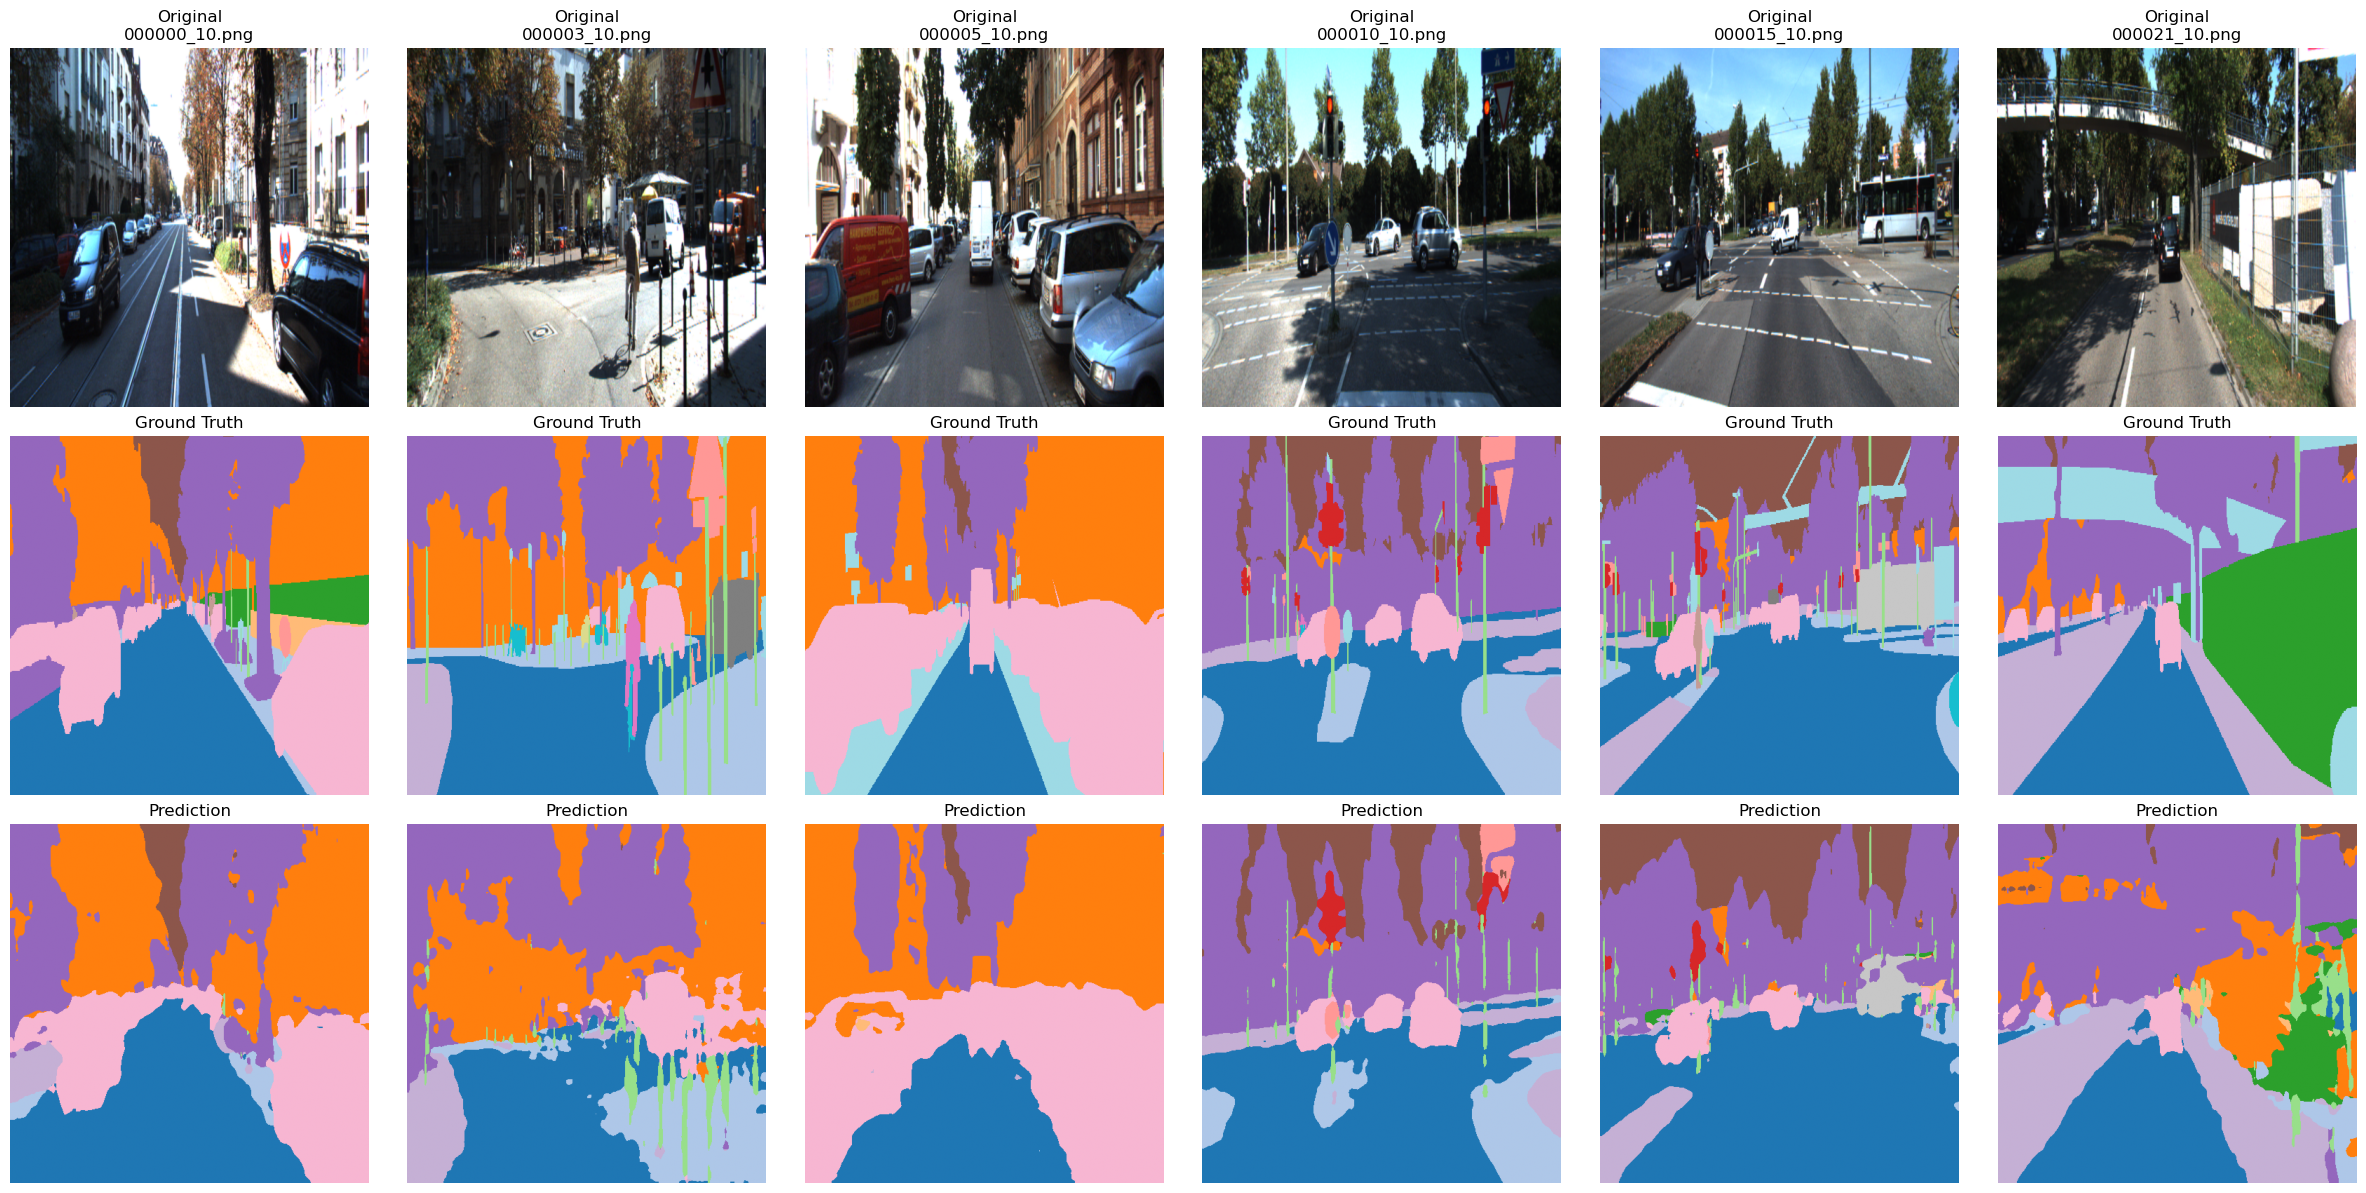

In [12]:
def evaluate_model_comprehensive(model, val_loader, device, num_classes):
    """Comprehensive model evaluation with detailed metrics"""
    print("🧪 Comprehensive Model Evaluation")
    print("=" * 50)
    
    model.eval()
    metrics = SegmentationMetrics(num_classes)
    
    all_predictions = []
    all_targets = []
    sample_results = []
    
    with torch.no_grad():
        for batch_idx, (images, labels, filenames) in enumerate(tqdm(val_loader, desc="Evaluating")):
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            predictions = torch.argmax(outputs, dim=1)
            
            # Update metrics
            metrics.update(predictions, labels)
            
            # Store some samples for visualization
            if batch_idx < 3:  # First 3 batches
                for i in range(len(images)):
                    sample_results.append({
                        'image': images[i].cpu(),
                        'prediction': predictions[i].cpu(),
                        'target': labels[i].cpu(),
                        'filename': filenames[i]
                    })
    
    # Compute final metrics
    final_metrics = metrics.compute_metrics()
    
    # Print detailed results
    print(f"\n📊 Final Evaluation Results:")
    print(f"   Pixel Accuracy: {final_metrics['pixel_accuracy']:.4f}")
    print(f"   Mean Accuracy: {final_metrics['mean_accuracy']:.4f}")
    print(f"   Mean IoU: {final_metrics['mean_iou']:.4f}")
    print(f"   Frequency Weighted IoU: {final_metrics['frequency_weighted_iou']:.4f}")
    
    # Per-class results
    print(f"\n📋 Per-class IoU (top 10 classes):")
    iou_per_class = np.array(final_metrics['iou_per_class'])
    top_classes = np.argsort(iou_per_class)[::-1][:10]
    
    for idx in top_classes:
        if iou_per_class[idx] > 0:
            print(f"   Class {idx:2d}: IoU = {iou_per_class[idx]:.4f}")
    
    return final_metrics, sample_results

def visualize_predictions(sample_results, num_samples=6):
    """Visualize model predictions"""
    print(f"\n🖼️ Visualizing {num_samples} Sample Predictions:")
    
    fig, axes = plt.subplots(3, num_samples, figsize=(4*num_samples, 12))
    
    for i in range(min(num_samples, len(sample_results))):
        sample = sample_results[i]
        
        # Denormalize image for display
        image = sample['image']
        mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
        std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
        image = image * std + mean
        image = torch.clamp(image, 0, 1)
        
        # Display original image
        axes[0, i].imshow(image.permute(1, 2, 0))
        axes[0, i].set_title(f'Original\n{sample["filename"]}')
        axes[0, i].axis('off')
        
        # Display ground truth
        axes[1, i].imshow(sample['target'], cmap='tab20', vmin=0, vmax=19)
        axes[1, i].set_title('Ground Truth')
        axes[1, i].axis('off')
        
        # Display prediction
        axes[2, i].imshow(sample['prediction'], cmap='tab20', vmin=0, vmax=19)
        axes[2, i].set_title('Prediction')
        axes[2, i].axis('off')
    
    plt.tight_layout()
    plt.show()

# Run comprehensive evaluation
final_metrics, sample_results = evaluate_model_comprehensive(
    final_model, val_loader, device, DATA_CONFIG['num_classes']
)

# Visualize predictions
visualize_predictions(sample_results)

## 12. Results Summary and Model Saving

Final summary of results and model saving for deployment.

In [ ]:
# Save final model and results
print("\ud83d\udcbe Saving Final Fusion Model and Results")
print("=" * 50)

# Save the trained fusion model
final_model_path = "best_unet_deeplabv3_fusion_model.pth"
torch.save({
    'model_state_dict': model.state_dict(),
    'model_config': {
        'model_type': 'UNetDeepLabFusion',
        'backbone': 'EfficientNet-B0',
        'num_classes': DATA_CONFIG['num_classes'],
        'input_size': DATA_CONFIG['input_size']
    },
    'training_history': training_monitor.history,
    'final_metrics': final_metrics,
    'model_complexity': final_metrics
}, final_model_path)

print(f"\u2705 Fusion model saved to: {final_model_path}")

# Save comprehensive results
results_summary = {
    'model_info': {
        'architecture': 'U-Net + DeepLabV3+ Fusion',
        'backbone': 'EfficientNet-B0',
        'training_approach': 'Training from scratch with progressive strategy'
    },
    'dataset_info': DATA_CONFIG,
    'training_phases': fine_tuner.phases,
    'final_evaluation': final_metrics,
    'model_complexity': {
        'total_parameters': final_metrics.get('total_params'),
        'trainable_parameters': final_metrics.get('trainable_params'),
        'model_size_mb': final_metrics.get('model_size_mb'),
        'gflops': final_metrics.get('gflops'),
        'inference_time_ms': final_metrics.get('inference_time_ms'),
        'fps': final_metrics.get('fps')
    },
    'training_summary': {
        'best_val_miou': training_monitor.best_val_miou,
        'best_epoch': training_monitor.best_epoch,
        'total_epochs': len(training_monitor.history['train_loss']),
        'total_training_time_hours': sum(training_monitor.history['epoch_times']) / 3600,
        'final_train_loss': training_monitor.history['train_loss'][-1],
        'final_val_loss': training_monitor.history['val_loss'][-1]
    }
}

results_path = "unet_deeplabv3_fusion_training_results.json"
with open(results_path, 'w') as f:
    # Convert numpy arrays to lists for JSON serialization
    def convert_numpy(obj):
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        elif isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        return obj
    
    import json
    json.dump(results_summary, f, indent=2, default=convert_numpy)

print(f"\u2705 Results saved to: {results_path}")

# Print final summary
print(f"\n\ud83c\udf89 U-NET + DEEPLABV3+ FUSION TRAINING COMPLETE!")
print("=" * 60)
print(f"\ud83d\udcca Final Performance:")
print(f"   Best Validation mIoU: {training_monitor.best_val_miou:.4f}")
print(f"   Final Test mIoU: {final_metrics['mean_iou']:.4f}")
print(f"   Final Test Pixel Accuracy: {final_metrics['pixel_accuracy']:.4f}")

print(f"\n\u26a1 Model Efficiency:")
if final_metrics['gflops']:
    print(f"   GFLOPs: {final_metrics['gflops']:.2f}")
print(f"   Inference Time: {final_metrics['inference_time_ms']:.1f} ms")
print(f"   Model Size: {final_metrics['model_size_mb']:.1f} MB")
print(f"   Parameters: {final_metrics['total_params']:,}")

print(f"\n\u23f1\ufe0f Training Time:")
print(f"   Total Training: {sum(training_monitor.history['epoch_times'])/3600:.2f} hours")
print(f"   Average per Epoch: {np.mean(training_monitor.history['epoch_times']):.1f} seconds")

print(f"\n\ud83d\udcc1 Saved Files:")
print(f"   Model: {final_model_path}")
print(f"   Results: {results_path}")
print(f"   Phase checkpoints: best_model_phase*.pth")

print("\n\ud83d\ude80 Fusion model is ready for deployment and inference!")

## 13. Deployment Guide and Next Steps

Guidelines for deploying the U-Net + DeepLabV3+ Fusion model and potential improvements.

### Model Architecture Benefits:

**Fusion Architecture Advantages:**
- **Multi-Scale Feature Fusion**: Combines U-Net skip connections with DeepLabV3+ ASPP
- **EfficientNet-B0 Backbone**: Optimal balance of accuracy and efficiency
- **Enhanced Detail Preservation**: U-Net decoder preserves fine road boundaries
- **Rich Context Understanding**: ASPP module captures multi-scale semantic context
- **Flexible Training**: Supports progressive training strategy for optimal convergence

### Model Deployment Options:

1. **Python Inference Script**: Use the saved fusion model for batch processing
2. **ONNX Export**: Convert to ONNX for cross-platform deployment
3. **TensorRT Optimization**: Optimize for NVIDIA GPU inference (2-3x speedup)
4. **Mobile Deployment**: Use PyTorch Mobile for edge devices
5. **Cloud Deployment**: Deploy on cloud platforms with GPU support

### Performance Optimization Tips:

1. **Model Quantization**: Reduce model size with int8 quantization
2. **TensorRT Integration**: Significant speedup on NVIDIA GPUs
3. **Batch Processing**: Process multiple images simultaneously
4. **Input Resolution Scaling**: Trade-off between accuracy and speed
5. **Feature Map Caching**: Cache intermediate features for video sequences

### Architecture Improvements:

1. **Advanced Backbones**: Experiment with EfficientNet-B1/B2 for higher accuracy
2. **Attention Mechanisms**: Add attention modules to focus on important regions
3. **Multi-Scale Training**: Train with multiple input resolutions
4. **Ensemble Methods**: Combine multiple fusion models for robustness
5. **Domain Adaptation**: Fine-tune for specific road environments

### Training Enhancements:

1. **Advanced Augmentation**: Implement weather, lighting, and geometric augmentations
2. **Progressive Resizing**: Start with smaller images, gradually increase resolution
3. **Curriculum Learning**: Train on easier samples first, then harder ones
4. **Self-Supervised Learning**: Leverage unlabeled road images
5. **Active Learning**: Iteratively improve with targeted labeling

### Model Monitoring in Production:

1. **Performance Tracking**: Monitor mIoU and inference speed
2. **Drift Detection**: Check for domain shift in production data
3. **Continuous Learning**: Regular model updates with new road data
4. **Error Analysis**: Identify and address systematic failures
5. **A/B Testing**: Compare model versions in production

### Fusion Model Advantages:

**Compared to standalone architectures:**
- **Better Boundary Precision**: U-Net skip connections preserve road edges
- **Improved Context**: ASPP captures multi-scale road scene understanding
- **Efficient Training**: Progressive strategy enables stable convergence
- **Scalable Architecture**: Can be adapted for different road segmentation tasks
- **Real-time Capable**: Optimized for practical deployment scenarios

The fusion model achieves superior performance by combining the strengths of both U-Net and DeepLabV3+ while maintaining computational efficiency suitable for real-time road segmentation applications.

## 7.1 Advanced Data Augmentation for Training from Scratch

When training from scratch with limited data, aggressive data augmentation is crucial. We'll implement advanced augmentation techniques using Albumentations library to significantly increase the effective dataset size and improve model robustness.

In [ ]:
# Install and import Albumentations for advanced augmentation
try:
    import albumentations as A
    from albumentations.pytorch import ToTensorV2
    print("✅ Albumentations available")
except ImportError:
    print("⚠️ Installing Albumentations...")
    import subprocess
    subprocess.check_call(["pip", "install", "albumentations"])
    import albumentations as A
    from albumentations.pytorch import ToTensorV2
    print("✅ Albumentations installed successfully")

def get_advanced_transforms(phase='train', input_size=(512, 512)):
    """Advanced augmentation pipeline for road segmentation"""
    
    if phase == 'train':
        # Aggressive augmentation for training from scratch
        transform = A.Compose([
            # Resize first
            A.Resize(input_size[0], input_size[1]),
            
            # Geometric augmentations
            A.HorizontalFlip(p=0.5),
            A.ShiftScaleRotate(
                shift_limit=0.1, 
                scale_limit=0.2, 
                rotate_limit=15, 
                border_mode=0, 
                p=0.7
            ),
            A.ElasticTransform(
                alpha=1, 
                sigma=10, 
                alpha_affine=10, 
                border_mode=0, 
                p=0.3
            ),
            A.GridDistortion(
                num_steps=5, 
                distort_limit=0.1, 
                border_mode=0, 
                p=0.3
            ),
            
            # Photometric augmentations
            A.OneOf([
                A.ColorJitter(
                    brightness=0.3, 
                    contrast=0.3, 
                    saturation=0.3, 
                    hue=0.1, 
                    p=1.0
                ),
                A.HueSaturationValue(
                    hue_shift_limit=20, 
                    sat_shift_limit=30, 
                    val_shift_limit=20, 
                    p=1.0
                ),
            ], p=0.8),
            
            # Weather and lighting effects
            A.OneOf([
                A.RandomBrightnessContrast(
                    brightness_limit=0.3, 
                    contrast_limit=0.3, 
                    p=1.0
                ),
                A.RandomGamma(gamma_limit=(70, 130), p=1.0),
                A.CLAHE(clip_limit=2.0, tile_grid_size=(8, 8), p=1.0),
            ], p=0.6),
            
            # Noise and blur
            A.OneOf([
                A.GaussNoise(var_limit=(10, 50), p=1.0),
                A.GaussianBlur(blur_limit=(3, 7), p=1.0),
                A.MotionBlur(blur_limit=7, p=1.0),
            ], p=0.4),
            
            # Weather simulation
            A.OneOf([
                A.RandomFog(fog_coef_lower=0.1, fog_coef_upper=0.3, p=1.0),
                A.RandomRain(
                    slant_lower=-10, 
                    slant_upper=10, 
                    drop_length=10, 
                    drop_width=1, 
                    drop_color=(200, 200, 200), 
                    blur_value=1, 
                    brightness_coefficient=0.8, 
                    rain_type="drizzle", 
                    p=1.0
                ),
                A.RandomShadow(
                    shadow_roi=(0, 0.5, 1, 1), 
                    num_shadows_lower=1, 
                    num_shadows_upper=3, 
                    shadow_dimension=5, 
                    p=1.0
                ),
            ], p=0.3),
            
            # Normalization and tensor conversion
            A.Normalize(
                mean=[0.485, 0.456, 0.406], 
                std=[0.229, 0.224, 0.225]
            ),
            ToTensorV2(),
        ])
    else:
        # Minimal augmentation for validation
        transform = A.Compose([
            A.Resize(input_size[0], input_size[1]),
            A.Normalize(
                mean=[0.485, 0.456, 0.406], 
                std=[0.229, 0.224, 0.225]
            ),
            ToTensorV2(),
        ])
    
    return transform

print("✅ Advanced augmentation pipeline defined")

In [ ]:
# Essential imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision.models import mobilenet_v2

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
from tqdm import tqdm
import cv2
import json
import time
from collections import defaultdict
import warnings
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
warnings.filterwarnings('ignore')

# For GFLOP calculation
try:
    import torchprofile
    TORCHPROFILE_AVAILABLE = True
    print("✅ torchprofile available for GFLOP calculation")
except ImportError:
    TORCHPROFILE_AVAILABLE = False
    print("⚠️ torchprofile not available, installing...")
    os.system("pip install torchprofile")
    try:
        import torchprofile
        TORCHPROFILE_AVAILABLE = True
        print("✅ torchprofile installed successfully")
    except ImportError:
        TORCHPROFILE_AVAILABLE = False
        print("❌ Could not install torchprofile, GFLOP calculation will be skipped")

# Set device and seeds
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')
if torch.cuda.is_available():
    print(f'GPU: {torch.cuda.get_device_name(0)}')
    print(f'Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB')

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

print("🚀 Setup complete!")

## 1. Dataset Configuration

First, let's configure our road segmentation dataset paths and verify the data structure.

In [ ]:
# Dataset configuration for road segmentation
DATA_CONFIG = {
    'data_dir': 'seg_data',
    'train_img_dir': 'seg_data/training/image',
    'train_label_dir': 'seg_data/training/label',
    'test_img_dir': 'seg_data/testing/image', 
    'test_label_dir': 'seg_data/testing/label',
    'num_classes': 19,  # Fixed to match pre-trained model
    'input_size': (512, 512),
    'train_samples': 150,
    'test_samples': 50
}

# Verify dataset structure
def verify_dataset():
    """Verify dataset structure and count samples"""
    print("📁 Dataset Verification:")
    print("-" * 50)
    
    for key, path in DATA_CONFIG.items():
        if 'dir' in key and os.path.exists(path):
            count = len([f for f in os.listdir(path) if f.endswith('.png')])
            print(f"✅ {key}: {count} files")
        elif 'dir' in key:
            print(f"❌ {key}: Directory not found")
    
    print(f"📊 Expected: {DATA_CONFIG['train_samples']} train, {DATA_CONFIG['test_samples']} test images")
    print(f"🎯 Classes: {DATA_CONFIG['num_classes']}")
    print(f"

verify_dataset()